# Введение

**Поставлена задача от обсерватории**, придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. 

    Обычно для расчёта температуры учёные пользуются следующими методами:
- Закон смещения Вина.
- Закон Стефана-Больцмана.
- Спектральный анализ.

Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.

В проекте необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

## 1 Загрузка данных

In [1]:
#!pip install -U skorch

In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import iplot
import matplotlib.patches as mpatches


from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV
from torch import optim
import torch.nn.functional as F
import torch
import torch.nn as nn
import skorch

In [3]:
df = pd.read_csv('/datasets/6_class.csv')
df.head(5)

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


В Data Frame 240 строк, 7 столбцов, значений NaN нет. Типы столбцов : int - 3 столбца, float - 3 столбца и object - столбец. Из первоначального осмотра Data Frame можно сделать вывод, что столбец Unnamed: 0 дублирует порядковый номер объектов в таблице. В предобработке его удалим.

## 2 Предобработка и анализ данных

### 2.1 Переименовывание столбцов

In [5]:
df = df.rename(columns = 
              {'Temperature (K)' : 'temperature_k',
               'Luminosity(L/Lo)' : 'luminosity_l_lo',
               'Radius(R/Ro)' : 'radius_r_ro',
               'Absolute magnitude(Mv)' : 'absolute_magnitude_mv',
               'Star type' : 'star_type',
               'Star color' : 'star_color',
               'Unnamed: 0' : 'un_named_0'}
              )

df.head(2)

,un_named_0,temperature_k,luminosity_l_lo,radius_r_ro,absolute_magnitude_mv,star_type,star_color
0,0,3068,0.0024,0.1700,16.12,0,Red
1,1,3042,0.0005,0.1542,16.60,0,Red


### 2.2 Проверка Data Frame на дубликаты

In [6]:
df.loc[df.duplicated()]

,un_named_0,temperature_k,luminosity_l_lo,radius_r_ro,absolute_magnitude_mv,star_type,star_color


Дубликатов в Data Frame нет

In [7]:
df['star_color'].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
white                   3
Yellowish White         3
Whitish                 2
yellowish               2
Orange                  2
Blue-White              1
Orange-Red              1
White-Yellow            1
Yellowish               1
Blue                    1
Pale yellow orange      1
Blue white              1
Name: star_color, dtype: int64

In [8]:
df['star_color'] = df['star_color'].str.lower()

Все строки в столбце 'star_color' привели к нижнему регистру.

In [9]:
df['star_color'] = df['star_color'].str.replace(r'.*blue-white.*', 'blue_white', regex= True)
df['star_color'] = df['star_color'].str.replace(r'.*blue white.*', 'blue_white', regex= True)
df['star_color'] = df['star_color'].str.replace(r'.*yellow-white.*', 'yellow_white', regex= True)
df['star_color'] = df['star_color'].str.replace(r'.*yellowish white.*', 'yellowish_white', regex= True)
df['star_color'] = df['star_color'].str.replace(r'.*pale yellow orange.*', 'pale_yellow_orange', regex= True)
df['star_color'] = df['star_color'].str.replace(r'.*white-yellow.*', 'yellow_white', regex= True)
df['star_color'] = df['star_color'].str.replace(r'.*orange-red.*', 'orange_red', regex= True)
df['star_color'] = df['star_color'].str.replace(r'.*yellowish_white.*', 'yellow_white', regex= True)
df['star_color'] = df['star_color'].str.replace(r'.*yellowish.*', 'yellow_white', regex= True)

Переименовали строки в столбце 'star_color', чтобы избавиться от повторов и комфортной работы с Data Frame

In [10]:
df["star_color"] = df["star_color"].map(str.strip)  # Удаляем пробелы в строках в столбце star_color

In [11]:
df['star_color'].value_counts()

red                   112
blue                   56
blue_white             41
yellow_white           15
white                  10
orange                  2
whitish                 2
orange_red              1
pale_yellow_orange      1
Name: star_color, dtype: int64

Лидирующую позицию занимают звезды, цвет которых "red", 2 и 3 место у "blue" и "blue_white", замыкает 5 лидеров звезды с цветом "white" и "yellow_white", остальных звезд в Data Frame очень мало.

### 2.3 Проверка Data Frame на отсутствующие значения

In [12]:
df.isnull().sum()

un_named_0               0
temperature_k            0
luminosity_l_lo          0
radius_r_ro              0
absolute_magnitude_mv    0
star_type                0
star_color               0
dtype: int64

Значений NaN в Data Frame нет.

### 2.4 Распределение данных в Data Frame

In [13]:
df.describe()

,un_named_0,temperature_k,luminosity_l_lo,radius_r_ro,absolute_magnitude_mv,star_type
count,240.00000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,119.50000,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,69.42622,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,0.00000,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,59.75000,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,119.50000,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,179.25000,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,239.00000,40000.000000,849420.000000,1948.500000,20.060000,5.000000


По распределению данных, никаких аномальных значений не наблюдается.

### 2.5 Копируем Data Frame

In [15]:
df_copy = df.copy()

Копируем Data Frame

### 2.6 Удаление ненужных столбцов

In [16]:
df = df.drop(['un_named_0'], axis=1)
df.head(2)

,temperature_k,luminosity_l_lo,radius_r_ro,absolute_magnitude_mv,star_type,star_color
0,3068,0.0024,0.1700,16.12,0,red
1,3042,0.0005,0.1542,16.60,0,red


Удалил ненужный столбец "Unnamed: 0"

### 2.7 Кодирование категориальных признаков

In [17]:
df = pd.get_dummies(df, columns=['star_color', 'star_type'], drop_first=True)
df.head(2)

,temperature_k,luminosity_l_lo,radius_r_ro,absolute_magnitude_mv,star_color_blue_white,star_color_orange,star_color_orange_red,star_color_pale_yellow_orange,star_color_red,star_color_white,star_color_whitish,star_color_yellow_white,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5
0,3068,0.0024,0.1700,16.12,0,0,0,0,1,0,0,0,0,0,0,0,0
1,3042,0.0005,0.1542,16.60,0,0,0,0,1,0,0,0,0,0,0,0,0


Кодировали категориальные признаки с помощью pd.get_dummies

### 2.8 Разбиение признаков

In [18]:
target_df = df['temperature_k']
features_df = df.drop('temperature_k', axis=1)

features_train_df, features_valid_df, target_train_df, target_valid_df = train_test_split(
    features_df.copy(), target_df.copy(), test_size=0.25, shuffle=True, random_state=69)

Разбили Data Frame в соотношении 75 / 25.

### 2.9 Масштабирование количественных признаков

In [19]:
num_col = ['luminosity_l_lo', 
           'radius_r_ro', 
           'absolute_magnitude_mv'
           ]


scaler = StandardScaler()
scaler.fit(features_train_df[num_col]) 

features_train_df[num_col] = scaler.transform(features_train_df[num_col])
features_valid_df[num_col] = scaler.transform(features_valid_df[num_col])


In [20]:
features_valid_df.head(2)  # Проверяем работу кода

,luminosity_l_lo,radius_r_ro,absolute_magnitude_mv,star_color_blue_white,star_color_orange,star_color_orange_red,star_color_pale_yellow_orange,star_color_red,star_color_white,star_color_whitish,star_color_yellow_white,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5
125,-0.609825,-0.461207,1.472190,0,0,0,0,1,0,0,0,0,0,0,0,0
194,-0.609825,-0.460835,0.789068,0,0,0,0,1,0,0,0,1,0,0,0,0


Масштабировали количественные признаки при помощи StandardScaler

## 3 Построение базовой нейронной сети

### 3.1 Переводим признаки в torch

In [34]:
X_train_df = torch.FloatTensor(features_train_df.values)
X_test_df = torch.FloatTensor(features_valid_df.values)
y_train_df = torch.FloatTensor(target_train_df.values)
y_test_df = torch.FloatTensor(target_valid_df.values)

Переводим признаки в тип torch

In [22]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)      


n_in_neurons = 16
n_hidden_neurons_1 = 14
n_hidden_neurons_2 = 8
n_out_neurons = 1

Первые 4 строки в ячейке выше, делают наш код повторяемым выдавая одни и те же числа. 4 последние строки - кол-во наших нейронов, 16 нейронов - кол-во наших признаков на входе, 14 и 8 - случайное кол-во нейронов в скрытых слоях и 1 нейрон на выходе, т к задача регрессии в которой нужно предсказать одно число - температуру.

In [23]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, dropout=0.1):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(16, 14)
        self.act1 = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
        self.fc2 = nn.Linear(14, 8)
        self.act2 = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        self.fc3 = nn.Linear(8, 1)
        

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)

        return x


In [24]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss

Создём класс, в котором считается RMSE

In [25]:
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

loss = RMSELoss()       # В качестве функции потерь используем RMSE

num_epochs = 6000

In [26]:
for epoch in range(num_epochs):
    optimizer.zero_grad()

    preds = net.forward(X_train_df).flatten()

    loss_value = loss(preds, y_train_df)

    loss_value.backward()

    optimizer.step()
    
        
    if epoch % 500 == 0 or epoch == num_epochs - 1:
        print('-' * 60)
        print('epoch {}, На обучающих данных loss {}'.format(epoch, loss_value.data))
  
    if epoch % 500 == 0 or epoch == num_epochs - 1:
        net.eval()
        test_preds = net.forward(X_test_df).flatten()
        rmse = loss(test_preds, y_test_df)
        
        
        print('epoch {}, На тестовых данных loss {}'.format(epoch, rmse.data))

------------------------------------------------------------
epoch 0, На обучающих данных loss 13711.4541015625
epoch 0, На тестовых данных loss 15498.875
------------------------------------------------------------
epoch 500, На обучающих данных loss 13602.212890625
epoch 500, На тестовых данных loss 15386.875
------------------------------------------------------------
epoch 1000, На обучающих данных loss 12885.1279296875
epoch 1000, На тестовых данных loss 14639.5615234375
------------------------------------------------------------
epoch 1500, На обучающих данных loss 11398.9580078125
epoch 1500, На тестовых данных loss 13026.6552734375
------------------------------------------------------------
epoch 2000, На обучающих данных loss 9568.2861328125
epoch 2000, На тестовых данных loss 10854.998046875
------------------------------------------------------------
epoch 2500, На обучающих данных loss 8180.19873046875
epoch 2500, На тестовых данных loss 8880.9990234375
------------------

Как видно из эпох на обучающих и тестовых данных, переобучения и недообучения нет.

In [27]:
one_df = pd.DataFrame(df_copy['temperature_k'].iloc[target_valid_df.index]).reset_index(drop=True)
tree_df = pd.DataFrame(df_copy['un_named_0'].iloc[target_valid_df.index]).reset_index(drop=True)
two_df = pd.DataFrame(test_preds.detach().numpy(), columns = ['predict_temperature_k'])

Берем ранее скопированный Data Frame со столбцом temperature_k и находим к нему индексы в target_valid_df и делаем reset_index для последующего объединения с предсказанными. Столбец un_named_0 нам нужен для того, чтобы знать порядковый номер звёзд в изначальном Data Frame.

In [28]:
df_pred_temper = pd.concat([tree_df, one_df, two_df], axis=1)          # Объединяем три Data Frame 
df_pred_temper.sort_values(by='un_named_0').head()

,un_named_0,temperature_k,predict_temperature_k
37,6,2637,2374.815918
18,8,2650,2370.227295
12,10,3600,3270.832764
16,13,3628,3282.279541
36,15,3340,3191.309814


В df_pred_temper в столбце un_named_0 содержатся старые индексы.

In [29]:
df_pred_temper['sequence_number'] = np.arange(df_pred_temper.shape[0])

Сделали порядковый номер строк, для построения графика, т к если строить график по начальным индексам, график становится не читабельным, поэтому добавляем новый столбец "sequence_number"

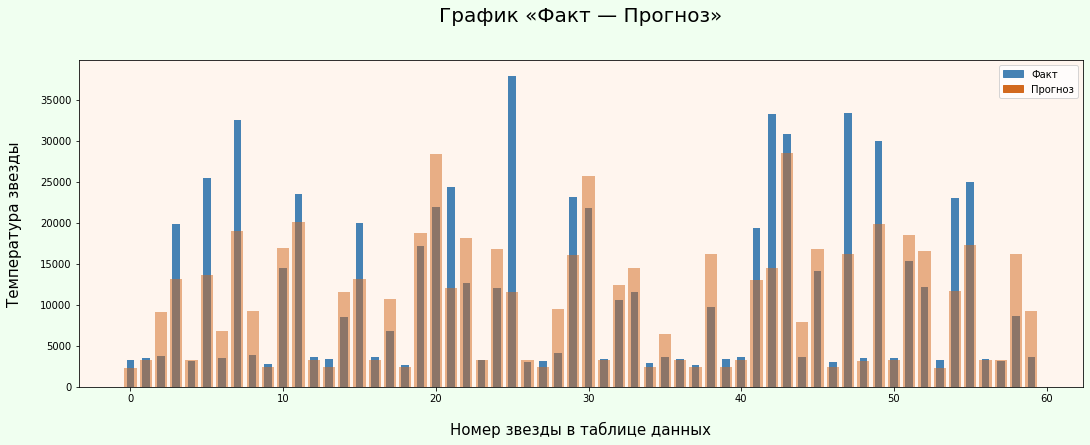

In [30]:
np.random.seed(0)

x = df_pred_temper.sequence_number
y1 = df_pred_temper.temperature_k
y2 = df_pred_temper.predict_temperature_k

fig, ax = plt.subplots()

ax.bar(x, y1, color = 'SteelBlue', width = 0.5)   
ax.bar(x, y2, color = 'Chocolate', alpha=0.5)

fig.set_figwidth(18)    
fig.set_figheight(6)  
fig.set_facecolor('Honeydew')
ax.set_facecolor('seashell')
ax.set_xlabel('Номер звезды в таблице данных', fontsize = 15, labelpad=18)
ax.set_ylabel('Температура звезды', fontsize = 15, labelpad=18)
plt.title('График «Факт — Прогноз»', fontsize=20,  y= 1.1)

fact = mpatches.Patch(color='SteelBlue', label='Факт')
forecast = mpatches.Patch(color='Chocolate', label='Прогноз')
plt.legend(handles=[fact, forecast])

plt.show()

Из графика можно сделать вывод, что некоторые звезды (температура звезд) практически совпадают с известными температурами этих звезд, есть небольшая погрешность, но есть и звезды (температура звезд) которые очень разнятся с реальной температурой звезды. Будем улучшать результат на следующем шаге.

## 4 Улучшение нейронной сети

In [31]:
X_trf = X_train_df
y_trf = y_train_df.reshape(-1, 1)

Переводим target в 2-d массив

In [35]:
class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()

        self.fc1 = nn.Linear(16, 14)
#        self.dp1 = nn.Dropout(p)
        
        self.fc2 = nn.Linear(14, 10)
#        self.dp2 = nn.Dropout(p)
        
        self.fc3 = nn.Linear(10, 6)
#        self.dp3 = nn.Dropout(p)
        
        self.fc4 = nn.Linear(6, 4)
#        self.dp4 = nn.Dropout(p)

        self.fc5 = nn.Linear(4, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
#        x = self.dp1(x)

        x = F.relu(self.fc2(x))
#        x = self.dp2(x)
        
        x = F.relu(self.fc3(x))
#        x = self.dp3(x)
        
        x = F.relu(self.fc4(x))
#        x = self.dp4(x)
        
        
        return self.fc5(x)

        
skorch_regressor = NeuralNetRegressor(module=Regressor, verbose=0)

Добавляем еще скрытый слой, без Dropout, т к он в нашем случае вредит обучению, а именно, ухутшается метрика

In [36]:
%%time
params = {
    "lr": [0.01, 0.02],
    "max_epochs": [100, 300],
    'optimizer': [optim.Adam, optim.RMSprop]
}

grid = GridSearchCV(skorch_regressor, params, scoring='neg_mean_squared_error', cv=3)

grid.fit(X_trf, y_trf)

CPU times: user 22.9 s, sys: 1.2 s, total: 24.1 s
Wall time: 24.5 s


GridSearchCV(cv=3,
             estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.Regressor'>,
),
             param_grid={'lr': [0.01, 0.02], 'max_epochs': [100, 300],
                         'optimizer': [<class 'torch.optim.adam.Adam'>,
                                       <class 'torch.optim.rmsprop.RMSprop'>]},
             scoring='neg_mean_squared_error')

Перебираем гиперпараметры с помощью сетки и GridSearchCV, в качестве scoring, выбираем MSE

In [37]:
grid.best_params_

{'lr': 0.02, 'max_epochs': 300, 'optimizer': torch.optim.rmsprop.RMSprop}

Лучшие гиперпараметры

In [ ]:
skorch_regressor = NeuralNetRegressor(module=Regressor, 
                                      lr=0.01,
                                      optimizer=optim.Adam, 
                                      max_epochs=450, 
                                      optimizer__weight_decay=0.1,
                                      train_split=skorch.dataset.ValidSplit(5),
                                      verbose=0
                                     )

Подставляем в нашу модель лучшие гиперпараметры. train_split=skorch.dataset.ValidSplit(5) - позволяет нам не делать валидационную выбороку.

In [ ]:
skorch_regressor.fit(X_trf, y_trf)

Обучаем модель

In [ ]:
print("Train RMSE : {}".format(mean_squared_error(y_train_df, skorch_regressor.predict(X_train_df).reshape(-1))**0.5))
print("Test  RMSE : {}".format(mean_squared_error(y_test_df, skorch_regressor.predict(X_test_df).reshape(-1))**0.5))

Делаем предсказания на обучающей и тестовой выборке

## 5 Выводы

В данном проекте использовали нейросеть для определения температуры на поверхности обнаруженных звёзд, исходя из существующих данных. В нашем Data Frame 240 строк, 7 столбцов, значений NaN нет. Типы столбцов : int - 3 столбца, float - 3 столбца и object - столбец. 

    Проделанные работы над нашим Data Frame: 
        - Переименовали столбцы.
        - Проверили Data Frame на дубликаты.
        - Проверили Data Frame на отсутствующие значения.
        - Посмотрели распределение данных.
        - Удалили ненужные столбцы.
        - Кодировали категориальные признаки с помощью pd.get_dummies.
        - Разбили признаки на обучающие и тестовые данные.
        - Масштабировали колличественные признаки.
        - Построили базовую нейронную сеть.
        - Улучшили нашу нейронную сеть, приведя метрику RMSE до 4500.
        
В базовой нейронной сети мы использовали 2 скрытых слоя, в 1 слое 14 нейронов, а во 2 слое 8 нейронов. Использовали функцию активации ReLU. На обучающих данных RMSE = 6188.12 и На тестовых данных RMSE = 6778.57. 

Для улучшения нашей нейронной сети мы использовали увеличение кол-ва наших скрытых слоев до 4. В 1 слое 14 нейронов, во 2 слое 10 нейронов, в 3 слое 6 нейронов и в 4 - 4 нейрона. Использовали функцию активации ReLU на всех скрытых слоях. Dropout не использовали, т к в нашем случае, он вредил метрике.